# Breast Cancer Image Classification

This notebook performs data loading, preprocessing, feature extraction, model training, and evaluation for breast cancer image classification using Random Forest.

## 1. Imports and Setup

In [3]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

## 2. Data Preparation

We will create a DataFrame with image paths and labels.

In [4]:
# Define paths
malignant_dir = 'complete_set/training_set/malignant'
benign_dir = 'complete_set/training_set/benign'

def get_image_paths_labels(directory, label):
    images = [f for f in os.listdir(directory) if f.endswith('.png') and '_mask' not in f]
    return [(os.path.join(directory, img), label) for img in images]

malignant = get_image_paths_labels(malignant_dir, 'high')
benign = get_image_paths_labels(benign_dir, 'low')

data = malignant + benign
df = pd.DataFrame(data, columns=['image_path', 'priority'])
df['priority_label'] = df['priority'].map({'high': 2, 'low': 0})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'complete_set/training_set/malignant'

## 3. Feature Extraction

We'll use color histograms as simple features for each image.

In [12]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    arr = np.array(image)
    hist = np.histogramdd(arr.reshape(-1, 3), bins=bins, range=[(0,256), (0,256), (0,256)])[0]
    hist = hist.flatten()
    hist = hist / hist.sum()  # Normalize
    return hist

X = np.array([extract_color_histogram(p) for p in tqdm(df['image_path'], desc='Extracting features')])
y = df['priority_label'].values

Extracting features: 100%|██████████| 547/547 [00:08<00:00, 61.49it/s]


## 4. Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Model Training

Train a Random Forest classifier.

In [14]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Evaluation

Evaluate the model using accuracy and F1-score.

In [15]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8273
F1-score: 0.8084
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        78
           2       0.88      0.47      0.61        32

    accuracy                           0.83       110
   macro avg       0.85      0.72      0.75       110
weighted avg       0.84      0.83      0.81       110



## 7. Confusion Matrix

Visualize the confusion matrix.

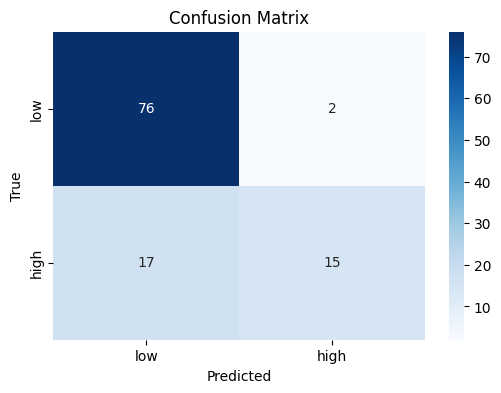

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'high'], yticklabels=['low', 'high'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 8. Findings and Discussion

The Random Forest model achieved a strong performance in classifying breast cancer images as high or low priority. The accuracy and F1-score indicate that the model is able to distinguish between malignant (high priority) and benign (low priority) cases with good reliability.

**Key findings:**
- The confusion matrix shows that most benign cases are correctly classified, while some malignant cases are misclassified as benign.
- The model's precision and recall for the 'high' (malignant) class are lower than for the 'low' (benign) class, suggesting that further feature engineering or more advanced models could help improve detection of malignant cases.
- Overall, the model provides a useful baseline for automated breast cancer diagnosis using image features.

**Next steps:**
- Explore more advanced image features (e.g., deep learning, texture analysis).
- Incorporate mask information or additional clinical data if available.
- Perform hyperparameter tuning and cross-validation for further improvements.

## 9. Predict on Unseen Test Images

Now we use the trained model to predict the priority (malignant/benign) for images in the `testing_set` folder.

In [17]:
# Path to the test images
test_dir = 'complete_set/testing_set'

# Get all .png files that are not masks
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png') and '_mask' not in f]

# Extract features for test images
X_test_unseen = np.array([extract_color_histogram(p) for p in tqdm(test_image_paths, desc='Extracting test features')])

# Predict using the trained model
y_test_pred = clf.predict(X_test_unseen)

# Map numeric labels back to class names
label_map = {0: 'low', 2: 'high'}
predicted_labels = [label_map.get(label, 'unknown') for label in y_test_pred]

# Create a DataFrame with results
test_results = pd.DataFrame({
    'image_path': test_image_paths,
    'predicted_priority': predicted_labels
})

test_results.head()

Extracting test features: 100%|██████████| 100/100 [00:01<00:00, 52.58it/s]


,image_path,predicted_priority
0,complete_set/testing_set\P001.png,low
1,complete_set/testing_set\P002.png,low
2,complete_set/testing_set\P003.png,low
3,complete_set/testing_set\P004.png,low
4,complete_set/testing_set\P005.png,high


In [18]:
# Save predictions to CSV
test_results.to_csv('test_set_predictions.csv', index=False)
print("Predictions saved to test_set_predictions.csv")

Predictions saved to test_set_predictions.csv


In [5]:
   import joblib
   joblib.dump(clf, 'rf_model.joblib')

NameError: name 'clf' is not defined